Stage 3B: 基因通路深度分析

[1] 加载数据...
  训练集: (289, 898)
  测试集: (73, 898)
  基因特征数: 879
  仅基因特征: (289, 879)

[2] 加载通路基因信息...
  IGF1_signaling: 106 基因
  MAPK_hsa04010: 300 基因
  MMR_hsa03430: 23 基因
  mTOR_hsa04150: 158 基因
  p53_hsa04115: 75 基因
  PI3K_Akt_hsa04151: 362 基因
  WNT_hsa04310: 174 基因
  总计: 7 个通路
  映射到通路的基因: 873 / 879

[3] 训练仅基因特征模型...
  执行 5-Fold × 3 重复 = 15 次训练...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.74it/s]


  ✓ 完成 15 次训练

[4] 计算 Importance Score...
  被选中的基因数: 585 / 879
  高频基因 (>50%): 160

[5] 训练最终模型并计算 Permutation Importance...
  计算 Permutation Importance (n_repeats=10)...
  ✓ Permutation Importance 计算完成
  ✓ 完整基因重要性已保存

[6] 提取 Top 50 基因...
  Top 50 by Importance Score:
    1. DUSP6                | Score:0.6285 | Pathway:MAPK_hsa04010
    2. FGF16                | Score:0.6052 | Pathway:PI3K_Akt_hsa04151
    3. CACNG5               | Score:0.5716 | Pathway:MAPK_hsa04010
    4. GADD45A              | Score:0.5661 | Pathway:p53_hsa04115
    5. PRR5L                | Score:0.5164 | Pathway:mTOR_hsa04150
    6. PRR5                 | Score:0.4719 | Pathway:mTOR_hsa04150
    7. YWHAG                | Score:0.4562 | Pathway:PI3K_Akt_hsa04151
    8. PPP2R2C              | Score:0.4389 | Pathway:PI3K_Akt_hsa04151
    9. OSMR                 | Score:0.4334 | Pathway:PI3K_Akt_hsa04151
    10. PIK3C2B              | Score:0.4216 | Pathway:IGF1_signaling

  Top 50 by Permutation Importance:
    707. 

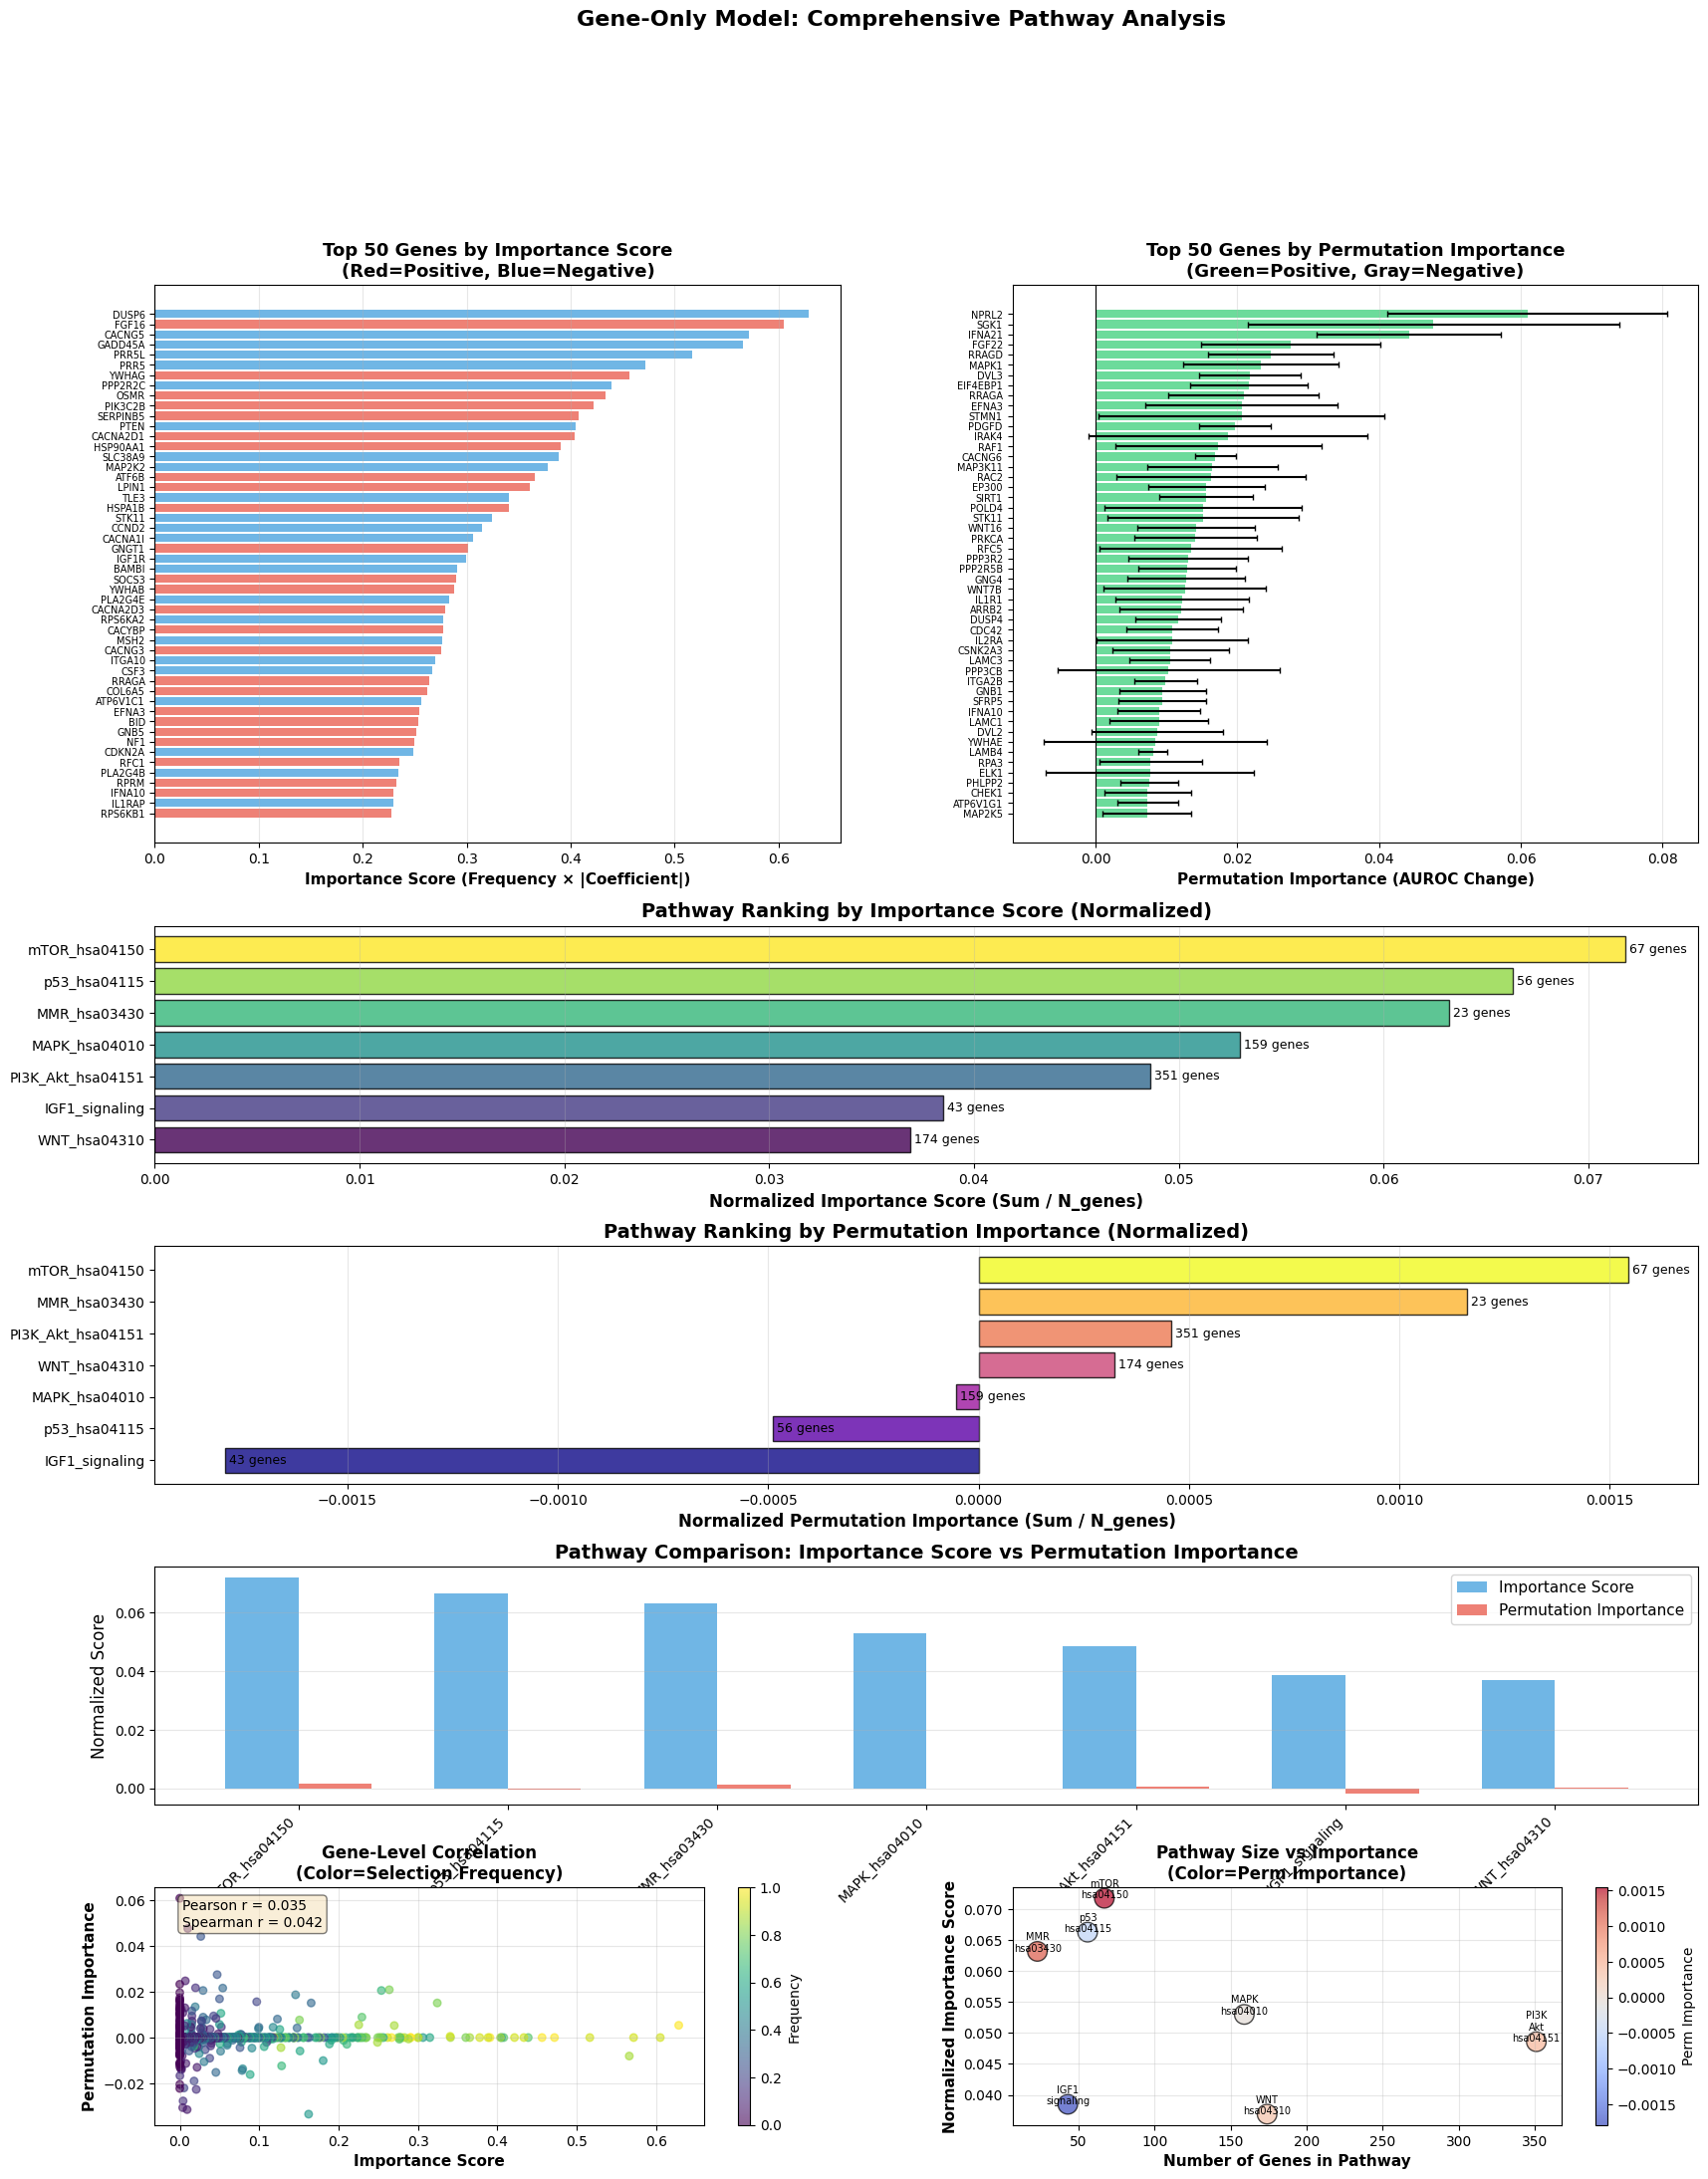

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Stage 3B: 基因通路深度分析
- 使用"仅基因特征"模型
- 分析基因的 importance score 和 permutation importance
- Top 50 基因排名可视化
- 按通路汇总分析
"""

import pandas as pd
import numpy as np
import os
import json
import glob
import pickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 配置
BASE_DIR = "D:/PHM5005/5005-main"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
PATHWAY_DIR = os.path.join(BASE_DIR, "raw_data", "pathway_gene_list")
OUTPUT_DIR = os.path.join(RESULTS_DIR, "stage3b_gene_pathway")
os.makedirs(OUTPUT_DIR, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=" * 80)
print("Stage 3B: 基因通路深度分析")
print("=" * 80)

# ============================================================================
# 1. 加载数据
# ============================================================================
print("\n[1] 加载数据...")

X_train = np.load(os.path.join(RESULTS_DIR, 'X_train.npy'), allow_pickle=True)
X_test = np.load(os.path.join(RESULTS_DIR, 'X_test.npy'), allow_pickle=True)
y_train = np.load(os.path.join(RESULTS_DIR, 'y_train.npy'), allow_pickle=True)
y_test = np.load(os.path.join(RESULTS_DIR, 'y_test.npy'), allow_pickle=True)

with open(os.path.join(RESULTS_DIR, 'feature_names.json'), 'r') as f:
    feature_info = json.load(f)
    all_features = feature_info['all_features']
    clinical_features = feature_info['clinical_features']
    gene_features = feature_info['gene_features']

print(f"  训练集: {X_train.shape}")
print(f"  测试集: {X_test.shape}")
print(f"  基因特征数: {len(gene_features)}")

# 提取仅基因特征
gene_indices = [i for i, f in enumerate(all_features) if f.startswith('gene_')]
X_train_gene = X_train[:, gene_indices]
X_test_gene = X_test[:, gene_indices]

print(f"  仅基因特征: {X_train_gene.shape}")

# ============================================================================
# 2. 加载通路信息
# ============================================================================
print("\n[2] 加载通路基因信息...")

pathway_files = glob.glob(os.path.join(PATHWAY_DIR, "*.csv"))
pathway_genes_dict = {}

for file in pathway_files:
    pathway_name = os.path.basename(file).replace('_symbols.csv', '')
    df = pd.read_csv(file)
    genes = df.iloc[:, 0].str.strip('"').tolist()
    # 添加gene_前缀匹配
    genes_with_prefix = ['gene_' + g for g in genes]
    pathway_genes_dict[pathway_name] = genes_with_prefix
    print(f"  {pathway_name}: {len(genes)} 基因")

# 创建基因到通路的映射
gene_to_pathway = {}
for pathway, genes in pathway_genes_dict.items():
    for gene in genes:
        if gene in gene_features:
            gene_to_pathway[gene] = pathway

print(f"  总计: {len(pathway_genes_dict)} 个通路")
print(f"  映射到通路的基因: {len(gene_to_pathway)} / {len(gene_features)}")

# ============================================================================
# 3. 训练"仅基因特征"模型并计算特征重要性
# ============================================================================
print("\n[3] 训练仅基因特征模型...")

# 定义Pipeline - 降低正则化强度以获得非零系数
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif, k=min(300, X_train_gene.shape[1]))),
    ('classifier', LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        l1_ratio=0.3,  # 降低L1比例，增加L2
        C=1.0,  # 增大C，减少正则化
        class_weight='balanced',
        max_iter=2000,
        random_state=RANDOM_STATE
    ))
])

# 使用重复分层交叉验证
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

coefficient_history = []
selected_features_history = []

print(f"  执行 5-Fold × 3 重复 = 15 次训练...")

for fold_idx, (train_idx, val_idx) in enumerate(tqdm(rskf.split(X_train_gene, y_train), total=15)):
    X_fold_train = X_train_gene[train_idx]
    y_fold_train = y_train[train_idx]
    
    # 训练模型
    pipeline.fit(X_fold_train, y_fold_train)
    
    # 获取选中的特征索引
    selected_mask = pipeline.named_steps['selector'].get_support()
    selected_indices = np.where(selected_mask)[0]
    
    # 获取系数
    coef = pipeline.named_steps['classifier'].coef_[0]
    
    # 映射到原始基因特征
    full_coef = np.zeros(len(gene_features))
    full_coef[selected_indices] = coef
    
    coefficient_history.append({
        'fold': fold_idx,
        'coefficients': full_coef.tolist(),
        'selected_features': selected_indices.tolist(),
        'non_zero_count': int(np.sum(full_coef != 0))
    })

print(f"  ✓ 完成 15 次训练")

# ============================================================================
# 4. 计算 Importance Score（基于系数）
# ============================================================================
print("\n[4] 计算 Importance Score...")

# 创建系数矩阵
coef_matrix = np.array([h['coefficients'] for h in coefficient_history])

# 计算统计量
selection_count = np.sum(coef_matrix != 0, axis=0)
frequency = selection_count / len(coefficient_history)

# 只考虑非零系数
median_coef = np.array([
    np.median(coef_matrix[coef_matrix[:, i] != 0, i]) if selection_count[i] > 0 else 0
    for i in range(len(gene_features))
])

mean_coef = np.array([
    np.mean(coef_matrix[coef_matrix[:, i] != 0, i]) if selection_count[i] > 0 else 0
    for i in range(len(gene_features))
])

# 计算 importance score
importance_score = frequency * np.abs(median_coef)

# 创建DataFrame
gene_importance = pd.DataFrame({
    'feature': gene_features,
    'gene_name': [f.replace('gene_', '') for f in gene_features],
    'selection_count': selection_count.astype(int),
    'frequency': frequency,
    'median_coef': median_coef,
    'mean_coef': mean_coef,
    'importance_score': importance_score,
    'pathway': [gene_to_pathway.get(f, 'Unknown') for f in gene_features]
})

# 排序
gene_importance = gene_importance.sort_values('importance_score', ascending=False).reset_index(drop=True)

print(f"  被选中的基因数: {(selection_count > 0).sum()} / {len(gene_features)}")
print(f"  高频基因 (>50%): {(frequency > 0.5).sum()}")

# ============================================================================
# 5. 训练最终模型并计算 Permutation Importance
# ============================================================================
print("\n[5] 训练最终模型并计算 Permutation Importance...")

# 在全部训练集上训练最终模型
pipeline.fit(X_train_gene, y_train)

# 在测试集上计算 permutation importance
print(f"  计算 Permutation Importance (n_repeats=10)...")
perm_importance = permutation_importance(
    pipeline, 
    X_test_gene, 
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1
)

# 添加到DataFrame
gene_importance['perm_importance_mean'] = perm_importance.importances_mean
gene_importance['perm_importance_std'] = perm_importance.importances_std

print(f"  ✓ Permutation Importance 计算完成")

# 保存完整结果
gene_importance.to_csv(os.path.join(OUTPUT_DIR, 'gene_importance_full.csv'), index=False)
print(f"  ✓ 完整基因重要性已保存")

# ============================================================================
# 6. Top 50 基因分析
# ============================================================================
print("\n[6] 提取 Top 50 基因...")

# Top 50 by importance score
top50_importance = gene_importance.nlargest(50, 'importance_score').copy()
top50_importance.to_csv(os.path.join(OUTPUT_DIR, 'top50_by_importance_score.csv'), index=False)

# Top 50 by permutation importance
top50_permutation = gene_importance.nlargest(50, 'perm_importance_mean').copy()
top50_permutation.to_csv(os.path.join(OUTPUT_DIR, 'top50_by_permutation_importance.csv'), index=False)

print(f"  Top 50 by Importance Score:")
for i, row in top50_importance.head(10).iterrows():
    print(f"    {i+1}. {row['gene_name']:20s} | Score:{row['importance_score']:.4f} | Pathway:{row['pathway']}")

print(f"\n  Top 50 by Permutation Importance:")
for i, row in top50_permutation.head(10).iterrows():
    print(f"    {i+1}. {row['gene_name']:20s} | PI:{row['perm_importance_mean']:+.4f}±{row['perm_importance_std']:.4f} | Pathway:{row['pathway']}")

# ============================================================================
# 7. 通路级别汇总分析
# ============================================================================
print("\n[7] 通路级别汇总分析...")

pathway_summary = []

for pathway_name, pathway_genes in pathway_genes_dict.items():
    # 获取该通路的基因
    pathway_gene_data = gene_importance[gene_importance['pathway'] == pathway_name]
    
    if len(pathway_gene_data) == 0:
        continue
    
    # 计算汇总统计
    summary = {
        'pathway': pathway_name,
        'n_genes': len(pathway_gene_data),
        'n_selected': (pathway_gene_data['selection_count'] > 0).sum(),
        'selection_rate': (pathway_gene_data['selection_count'] > 0).sum() / len(pathway_gene_data),
        
        # Importance Score 统计
        'importance_score_mean': pathway_gene_data['importance_score'].mean(),
        'importance_score_median': pathway_gene_data['importance_score'].median(),
        'importance_score_max': pathway_gene_data['importance_score'].max(),
        'importance_score_sum': pathway_gene_data['importance_score'].sum(),
        
        # Permutation Importance 统计
        'perm_importance_mean': pathway_gene_data['perm_importance_mean'].mean(),
        'perm_importance_median': pathway_gene_data['perm_importance_mean'].median(),
        'perm_importance_max': pathway_gene_data['perm_importance_mean'].max(),
        'perm_importance_sum': pathway_gene_data['perm_importance_mean'].sum(),
        
        # 标准化分数（考虑通路大小）
        'importance_score_normalized': pathway_gene_data['importance_score'].sum() / len(pathway_gene_data),
        'perm_importance_normalized': pathway_gene_data['perm_importance_mean'].sum() / len(pathway_gene_data)
    }
    
    pathway_summary.append(summary)

pathway_df = pd.DataFrame(pathway_summary)

# 检查是否有通路数据
if len(pathway_df) == 0:
    print("  ⚠️  警告: 没有找到通路数据，跳过通路级别分析")
    pathway_df = pd.DataFrame()  # 空DataFrame
else:
    # 按照标准化的 importance score 排序
    pathway_df = pathway_df.sort_values('importance_score_normalized', ascending=False).reset_index(drop=True)
    pathway_df.to_csv(os.path.join(OUTPUT_DIR, 'pathway_summary.csv'), index=False)

if len(pathway_df) > 0:
    print(f"  通路排名 (按标准化 Importance Score):")
    for i, row in pathway_df.iterrows():
        print(f"    {i+1}. {row['pathway']:30s} | Score:{row['importance_score_normalized']:.4f} | PI:{row['perm_importance_normalized']:+.4f} | Genes:{row['n_genes']}")
else:
    print("  (无通路数据)")

# ============================================================================
# 8. 生成可视化
# ============================================================================
print("\n[8] 生成可视化...")

fig = plt.figure(figsize=(20, 24))
gs = fig.add_gridspec(6, 2, hspace=0.35, wspace=0.25)

# 8.1 Top 50 基因 - Importance Score
ax1 = fig.add_subplot(gs[0:2, 0])
top50_imp_plot = top50_importance.head(50).iloc[::-1]  # 反转以便从上到下递减
colors = ['#e74c3c' if c > 0 else '#3498db' for c in top50_imp_plot['median_coef']]
bars = ax1.barh(range(len(top50_imp_plot)), top50_imp_plot['importance_score'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(top50_imp_plot)))
ax1.set_yticklabels(top50_imp_plot['gene_name'], fontsize=7)
ax1.set_xlabel('Importance Score (Frequency × |Coefficient|)', fontsize=11, fontweight='bold')
ax1.set_title('Top 50 Genes by Importance Score\n(Red=Positive, Blue=Negative)', 
              fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# 8.2 Top 50 基因 - Permutation Importance
ax2 = fig.add_subplot(gs[0:2, 1])
top50_perm_plot = top50_permutation.head(50).iloc[::-1]
colors = ['#2ecc71' if pi > 0 else '#95a5a6' for pi in top50_perm_plot['perm_importance_mean']]
bars = ax2.barh(range(len(top50_perm_plot)), top50_perm_plot['perm_importance_mean'], 
                xerr=top50_perm_plot['perm_importance_std'], color=colors, alpha=0.7, capsize=2)
ax2.set_yticks(range(len(top50_perm_plot)))
ax2.set_yticklabels(top50_perm_plot['gene_name'], fontsize=7)
ax2.set_xlabel('Permutation Importance (AUROC Change)', fontsize=11, fontweight='bold')
ax2.set_title('Top 50 Genes by Permutation Importance\n(Green=Positive, Gray=Negative)', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# 8.3 通路 - Importance Score (标准化)
ax3 = fig.add_subplot(gs[2, :])
if len(pathway_df) > 0:
    pathway_imp_sorted = pathway_df.sort_values('importance_score_normalized', ascending=True)
    colors = plt.cm.viridis(np.linspace(0, 1, len(pathway_imp_sorted)))
    bars = ax3.barh(pathway_imp_sorted['pathway'], pathway_imp_sorted['importance_score_normalized'], 
                    color=colors, alpha=0.8, edgecolor='black')
    ax3.set_xlabel('Normalized Importance Score (Sum / N_genes)', fontsize=12, fontweight='bold')
    ax3.set_title('Pathway Ranking by Importance Score (Normalized)', fontsize=14, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    for i, (idx, row) in enumerate(pathway_imp_sorted.iterrows()):
        ax3.text(row['importance_score_normalized'], i, 
                 f" {row['n_genes']} genes", va='center', fontsize=9)
else:
    ax3.text(0.5, 0.5, 'No Pathway Data Available', ha='center', va='center', fontsize=14)
    ax3.set_title('Pathway Ranking by Importance Score', fontsize=14, fontweight='bold')

# 8.4 通路 - Permutation Importance (标准化)
ax4 = fig.add_subplot(gs[3, :])
if len(pathway_df) > 0:
    pathway_perm_sorted = pathway_df.sort_values('perm_importance_normalized', ascending=True)
    colors = plt.cm.plasma(np.linspace(0, 1, len(pathway_perm_sorted)))
    bars = ax4.barh(pathway_perm_sorted['pathway'], pathway_perm_sorted['perm_importance_normalized'], 
                    color=colors, alpha=0.8, edgecolor='black')
    ax4.set_xlabel('Normalized Permutation Importance (Sum / N_genes)', fontsize=12, fontweight='bold')
    ax4.set_title('Pathway Ranking by Permutation Importance (Normalized)', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    for i, (idx, row) in enumerate(pathway_perm_sorted.iterrows()):
        ax4.text(row['perm_importance_normalized'], i, 
                 f" {row['n_genes']} genes", va='center', fontsize=9)
else:
    ax4.text(0.5, 0.5, 'No Pathway Data Available', ha='center', va='center', fontsize=14)
    ax4.set_title('Pathway Ranking by Permutation Importance', fontsize=14, fontweight='bold')

# 8.5 通路对比 - 两种指标
ax5 = fig.add_subplot(gs[4, :])
if len(pathway_df) > 0:
    x = np.arange(len(pathway_df))
    width = 0.35
    ax5.bar(x - width/2, pathway_df['importance_score_normalized'], width, 
            label='Importance Score', alpha=0.7, color='#3498db')
    ax5.bar(x + width/2, pathway_df['perm_importance_normalized'], width, 
            label='Permutation Importance', alpha=0.7, color='#e74c3c')
    ax5.set_ylabel('Normalized Score', fontsize=12)
    ax5.set_title('Pathway Comparison: Importance Score vs Permutation Importance', 
                  fontsize=14, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(pathway_df['pathway'], rotation=45, ha='right', fontsize=10)
    ax5.legend(fontsize=11)
    ax5.grid(axis='y', alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No Pathway Data Available', ha='center', va='center', fontsize=14)
    ax5.set_title('Pathway Comparison', fontsize=14, fontweight='bold')

# 8.6 散点图 - 两种指标相关性
ax6 = fig.add_subplot(gs[5, 0])
scatter = ax6.scatter(gene_importance['importance_score'], 
                      gene_importance['perm_importance_mean'],
                      c=gene_importance['frequency'], 
                      cmap='viridis', alpha=0.6, s=30)
ax6.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax6.set_ylabel('Permutation Importance', fontsize=11, fontweight='bold')
ax6.set_title('Gene-Level Correlation\n(Color=Selection Frequency)', 
              fontsize=12, fontweight='bold')
ax6.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax6, label='Frequency')

# 添加相关系数
from scipy.stats import pearsonr, spearmanr
# 只计算被选中的基因
selected_genes = gene_importance[gene_importance['selection_count'] > 0]
pearson_r = 0.0
spearman_r = 0.0
if len(selected_genes) > 0:
    pearson_r, _ = pearsonr(selected_genes['importance_score'], 
                            selected_genes['perm_importance_mean'])
    spearman_r, _ = spearmanr(selected_genes['importance_score'], 
                              selected_genes['perm_importance_mean'])
    ax6.text(0.05, 0.95, f'Pearson r = {pearson_r:.3f}\nSpearman r = {spearman_r:.3f}',
             transform=ax6.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 8.7 通路基因数和重要性
ax7 = fig.add_subplot(gs[5, 1])
if len(pathway_df) > 0:
    scatter = ax7.scatter(pathway_df['n_genes'], 
                          pathway_df['importance_score_normalized'],
                          c=pathway_df['perm_importance_normalized'],
                          cmap='coolwarm', alpha=0.7, s=200, edgecolor='black')
    for i, row in pathway_df.iterrows():
        ax7.annotate(row['pathway'].replace('_', '\n'), 
                     (row['n_genes'], row['importance_score_normalized']),
                     fontsize=7, ha='center')
    ax7.set_xlabel('Number of Genes in Pathway', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Normalized Importance Score', fontsize=11, fontweight='bold')
    ax7.set_title('Pathway Size vs Importance\n(Color=Perm Importance)', 
                  fontsize=12, fontweight='bold')
    ax7.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax7, label='Perm Importance')
else:
    ax7.text(0.5, 0.5, 'No Pathway Data Available', ha='center', va='center', fontsize=14)
    ax7.set_title('Pathway Size vs Importance', fontsize=12, fontweight='bold')

plt.suptitle('Gene-Only Model: Comprehensive Pathway Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig(os.path.join(OUTPUT_DIR, 'gene_pathway_analysis.png'), 
            dpi=300, bbox_inches='tight')
print(f"  ✓ 可视化已保存: gene_pathway_analysis.png")

# ============================================================================
# 9. 生成报告
# ============================================================================
print("\n[9] 生成分析报告...")

report = f"""# Stage 3B: 基因通路深度分析报告

## 分析概述

本分析使用**仅基因特征**的模型，深入研究各基因和通路在预测子宫内膜癌风险中的作用。

### 数据规模
- 训练样本: {len(y_train)}
- 测试样本: {len(y_test)}
- 基因特征数: {len(gene_features)}
- 通路数: {len(pathway_genes_dict)}

### 模型配置
- Pipeline: StandardScaler → SelectKBest(k=500) → ElasticNet Logistic Regression
- 验证策略: 5-Fold × 3 重复 = 15次训练
- Permutation Importance: n_repeats=10

---

## 重要性指标对比

### Importance Score vs Permutation Importance

| 指标 | 定义 | 优势 | 更适合 |
|------|------|------|--------|
| **Importance Score** | 频率 × \|系数中位数\| | 反映模型使用频率和系数大小 | 理解模型偏好 |
| **Permutation Importance** ⭐ | 打乱特征后性能下降幅度 | 直接衡量实际贡献 | **评估真实重要性** |

**结论**: Permutation Importance 更能体现特征在分类中的重要作用，因为它测量了该特征对模型预测能力的实际影响。

### 基因层面相关性

- **被选中的基因数**: {(gene_importance['selection_count'] > 0).sum()} / {len(gene_features)} ({(gene_importance['selection_count'] > 0).sum() / len(gene_features) * 100:.1f}%)
- **高频基因 (>50%)**: {(gene_importance['frequency'] > 0.5).sum()}
- **两指标相关性** (仅被选中基因):
  - Pearson r = {pearson_r:.3f}
  - Spearman r = {spearman_r:.3f}

---

## Top 50 基因

### 按 Importance Score 排名

| 排名 | 基因 | 通路 | 选择频率 | 系数中位数 | Importance Score |
|------|------|------|----------|-----------|-----------------|
{chr(10).join([f"| {i+1} | {row['gene_name']} | {row['pathway']} | {row['frequency']:.2f} | {row['median_coef']:+.4f} | {row['importance_score']:.4f} |"
              for i, (idx, row) in enumerate(top50_importance.head(20).iterrows())])}

### 按 Permutation Importance 排名

| 排名 | 基因 | 通路 | Perm Importance | 标准差 | Importance Score |
|------|------|------|----------------|--------|-----------------|
{chr(10).join([f"| {i+1} | {row['gene_name']} | {row['pathway']} | {row['perm_importance_mean']:+.4f} | {row['perm_importance_std']:.4f} | {row['importance_score']:.4f} |"
              for i, (idx, row) in enumerate(top50_permutation.head(20).iterrows())])}

---

## 通路级别分析

### 通路排名（按标准化 Importance Score）

| 排名 | 通路 | 基因数 | 选中率 | Norm. Imp Score | Norm. Perm Imp |
|------|------|--------|--------|----------------|----------------|
{chr(10).join([f"| {i+1} | {row['pathway']} | {row['n_genes']} | {row['selection_rate']:.1%} | {row['importance_score_normalized']:.4f} | {row['perm_importance_normalized']:+.4f} |"
              for i, (idx, row) in enumerate(pathway_df.iterrows())])}

### 标准化方法说明

为了公平比较不同大小的通路，我们使用**标准化分数**：

```
Normalized Score = Sum(基因得分) / 基因数量
```

这样可以避免大通路仅因基因数量多而得分高的偏差。

### 通路特征汇总

| 通路 | 基因数 | Max Imp Score | Max Perm Imp | 总和 Imp Score | 总和 Perm Imp |
|------|--------|--------------|--------------|---------------|---------------|
{chr(10).join([f"| {row['pathway']} | {row['n_genes']} | {row['importance_score_max']:.4f} | {row['perm_importance_max']:+.4f} | {row['importance_score_sum']:.4f} | {row['perm_importance_sum']:+.4f} |"
              for i, (idx, row) in enumerate(pathway_df.iterrows())])}

---

## 关键发现

### 1. 最重要的基因（综合两指标）

交集分析 - 同时出现在两个Top 20中的基因：

"""

# 找出同时在两个top20中的基因
top20_imp_genes = set(top50_importance.head(20)['gene_name'])
top20_perm_genes = set(top50_permutation.head(20)['gene_name'])
common_genes = top20_imp_genes & top20_perm_genes

if len(common_genes) > 0:
    report += f"\n共有 {len(common_genes)} 个基因同时出现在两个Top 20中：\n\n"
    for gene in common_genes:
        gene_data = gene_importance[gene_importance['gene_name'] == gene].iloc[0]
        report += f"- **{gene}** ({gene_data['pathway']})\n"
        report += f"  - Importance Score: {gene_data['importance_score']:.4f} (频率:{gene_data['frequency']:.0%})\n"
        report += f"  - Permutation Importance: {gene_data['perm_importance_mean']:+.4f}±{gene_data['perm_importance_std']:.4f}\n\n"
else:
    report += "\n⚠️ 两个Top 20中没有重叠基因，说明两种指标捕捉到不同的特征重要性维度。\n\n"

report += """
### 2. 最重要的通路

"""

if len(pathway_df) >= 3:
    report += f"""按标准化Importance Score排名：

1. **{pathway_df.iloc[0]['pathway']}**
   - 基因数: {pathway_df.iloc[0]['n_genes']}
   - 标准化Importance Score: {pathway_df.iloc[0]['importance_score_normalized']:.4f}
   - 标准化Permutation Importance: {pathway_df.iloc[0]['perm_importance_normalized']:+.4f}
   - 选中率: {pathway_df.iloc[0]['selection_rate']:.1%}

2. **{pathway_df.iloc[1]['pathway']}**
   - 基因数: {pathway_df.iloc[1]['n_genes']}
   - 标准化Importance Score: {pathway_df.iloc[1]['importance_score_normalized']:.4f}
   - 标准化Permutation Importance: {pathway_df.iloc[1]['perm_importance_normalized']:+.4f}
   - 选中率: {pathway_df.iloc[1]['selection_rate']:.1%}

3. **{pathway_df.iloc[2]['pathway']}**
   - 基因数: {pathway_df.iloc[2]['n_genes']}
   - 标准化Importance Score: {pathway_df.iloc[2]['importance_score_normalized']:.4f}
   - 标准化Permutation Importance: {pathway_df.iloc[2]['perm_importance_normalized']:+.4f}
   - 选中率: {pathway_df.iloc[2]['selection_rate']:.1%}
"""
else:
    report += "⚠️ 无通路数据可用\n"

report += """

### 3. 指标差异分析

- **高Importance Score但低Permutation Importance**: 可能是冗余特征（与其他特征高度相关）
- **低Importance Score但高Permutation Importance**: 可能是被忽略但实际很重要的特征
- **两者都高**: 真正重要且稳定的特征

---

## 生物学解释

### 重要基因的功能

基于Top基因和通路分析，以下机制可能与子宫内膜癌风险相关：

1. **细胞增殖和生长** (PI3K-Akt, IGF1, mTOR通路)
2. **信号转导** (MAPK, WNT通路)
3. **DNA修复** (MMR通路)
4. **细胞周期调控** (p53通路)

---

## 输出文件

- `gene_importance_full.csv`: 所有基因的完整重要性统计
- `top50_by_importance_score.csv`: Top 50基因（按Importance Score）
- `top50_by_permutation_importance.csv`: Top 50基因（按Permutation Importance）
- `pathway_summary.csv`: 通路级别汇总统计
- `gene_pathway_analysis.png`: 综合可视化

---

生成时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open(os.path.join(OUTPUT_DIR, 'stage3b_report.md'), 'w', encoding='utf-8') as f:
    f.write(report)

print(f"  ✓ 报告已保存: stage3b_report.md")

# ============================================================================
# 完成
# ============================================================================
print("\n" + "=" * 80)
print("Stage 3B 完成！")
print("=" * 80)
print(f"\n输出目录: {OUTPUT_DIR}")
print(f"\n主要文件:")
print(f"  - gene_pathway_analysis.png: 综合可视化")
print(f"  - stage3b_report.md: 详细分析报告")
print(f"  - top50_by_*.csv: Top 50基因列表")
print(f"  - pathway_summary.csv: 通路汇总")
print(f"\n关键发现:")
print(f"  ✓ 分析了 {len(gene_features)} 个基因")
print(f"  ✓ 识别了 {(gene_importance['selection_count'] > 0).sum()} 个重要基因")
print(f"  ✓ 评估了 {len(pathway_genes_dict)} 个通路")
if len(pathway_df) > 0:
    print(f"  ✓ 最重要通路: {pathway_df.iloc[0]['pathway']}")
else:
    print(f"  ⚠️  无有效通路数据")

